In [1]:
import ast
import math
from typing import List
import warnings
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import spacy

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

/home/nshafiabadi/anaconda3/envs/virtualenv/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def plot_surprisals(words:List[str], surprisals_df):
    num_words = len(words)
    cols = min(num_words, 3)
    rows = math.ceil(num_words / cols)

    plt.style.use('ggplot')
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = np.atleast_2d(axs)

    for i, word in enumerate(words):   
        word_data = surprisals_df[surprisals_df['Token'] == word]
        if word_data.empty:
            print(f'No data found for the word "{word}"')
            continue

        ax = axs[i//cols, i%cols]
        ax.plot(word_data['Steps'], word_data['MeanSurprisal'], marker='o')
        ax.set_title(f'"{word}"')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Mean surprisal')
        # ax.set_xscale('log')
        ax.invert_yaxis()

    # Remove empty subplots
    for j in range(i+1, rows*cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()


In [3]:
def plot_all_in_one(words:List[str], surprisals_df):
    plt.style.use('ggplot')
    plt.figure(figsize=(4, 4))

    max_x = 0

    for i, word in enumerate(words):   
        word_data = surprisals_df[surprisals_df['Token'] == word]
        if word_data.empty:
            print(f'No data found for the word "{word}"')
            continue

        line, = plt.plot(word_data['Steps'], word_data['MeanSurprisal'], marker='o')

        # annotate the end of the line
        x = word_data['Steps'].iloc[-1]
        y = word_data['MeanSurprisal'].iloc[-1]
        plt.annotate(word, (x, y), textcoords="offset points", xytext=(+10,+0), color=line.get_color())

        max_x = max(max_x, x)

    xlim = plt.gca().get_xlim()
    plt.gca().set_xlim(xlim[0], max_x * 1.5)  # increase the maximum x value by 50%

    plt.title('All Words')
    plt.xlabel('Steps')
    plt.ylabel('Mean surprisal')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [5]:
wikitext_surprisals = '../results/bert_surprisals.txt'
surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

In [6]:
surprisals = (surprisals
    .sort_values(['Token', 'Steps'])
    .groupby('Token')
    .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0), 
                              StdevSurprisalDiff = x['StdevSurprisal'].diff().fillna(0)))
    .reset_index(drop=True))

surprisals.insert(0, 'Token', surprisals.pop('Token'))
surprisals = surprisals[surprisals['Token'].apply(lambda t: t.isascii() and not t.isdigit())]
surprisals

/tmp/ipykernel_605400/3822632482.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0),


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff
0,100th,0,3762,14.619419,0.510996,0.0,2,0.000000,0.000000
1,100th,20000,10,7.110159,0.964662,0.0,2,-7.509260,0.453667
2,100th,40000,10,8.165643,1.590769,0.0,2,1.055483,0.626106
3,100th,60000,7,7.027547,1.110843,0.0,2,-1.138095,-0.479925
4,100th,80000,1,4.709196,2.413492,0.0,2,-2.318352,1.302649
...,...,...,...,...,...,...,...,...,...
264794,zu,1600000,0,2.781154,3.277767,0.5,4,0.088716,0.182716
264795,zu,1700000,0,2.847632,3.296625,0.5,4,0.066478,0.018858
264796,zu,1800000,0,2.986036,3.461543,0.5,4,0.138404,0.164918
264797,zu,1900000,0,2.985156,3.501315,0.5,4,-0.000880,0.039771


In [7]:
surprisals['Token'].nunique()

9131

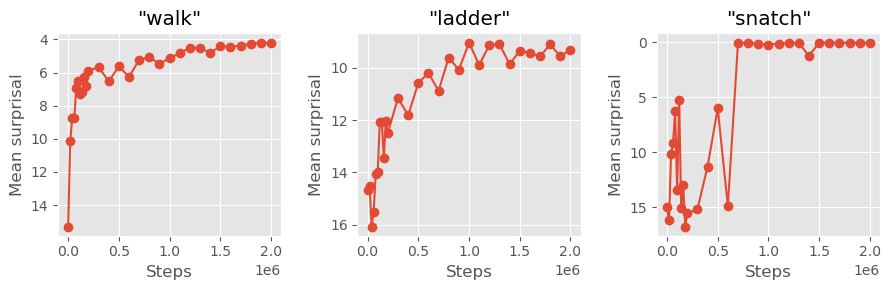

In [8]:
random_1 = random.choice(surprisals['Token'].unique().tolist())
random_2 = random.choice(surprisals['Token'].unique().tolist())
plot_surprisals(['walk', 'ladder', 'snatch'], surprisals)   # good choices: 'ladder', 'snatch'

### Most vs least frequent words

Percentage of frequent words in the dataset (occuring at least 512 times): 0.26%
Percentage of infrequent words in the dataset (occuring only once): 26.46%


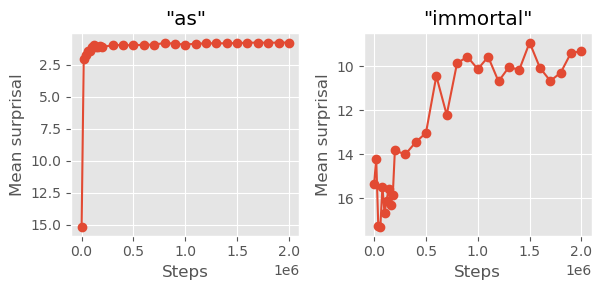

In [9]:
frequent = surprisals[surprisals['NumExamples'] == 512]
infrequent = surprisals[surprisals['NumExamples'] == 1]

print(f'Percentage of frequent words in the dataset (occuring at least 512 times): {len(frequent)/len(surprisals)*100:.2f}%')
print(f'Percentage of infrequent words in the dataset (occuring only once): {len(infrequent)/len(surprisals)*100:.2f}%')

plot_surprisals(
    frequent['Token'].drop_duplicates().sample(1).tolist() + infrequent['Token'].drop_duplicates().sample(1).tolist(), 
    surprisals
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


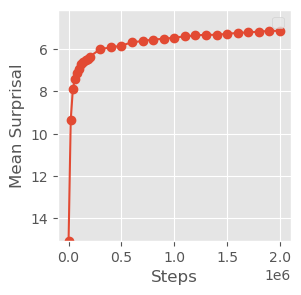

In [10]:
# for each step, average surprisal across all words
avg_surprisals = surprisals.groupby('Steps').MeanSurprisal.mean().reset_index().assign(Diffs=lambda x: x.MeanSurprisal.diff().fillna(0))

plt.figure(figsize=(3, 3))
plt.plot(avg_surprisals.Steps, avg_surprisals.MeanSurprisal, marker='o')
plt.ylim(avg_surprisals.MeanSurprisal.max(), avg_surprisals.MeanSurprisal.min()-1)
plt.xlabel('Steps')
plt.ylabel('Mean Surprisal')
plt.legend()

Frequent words (>= 512 examples):
Min surprisal: 0.79
Max surprisal (excluding the first step): 1.99
Average variability (excluding the first step): -0.04

Inrequent words (= 1 example):
Min surprisal: 6.23
Max surprisal (excluding the first step): 11.00
Average variability (excluding the first step): -0.18

Full corpus:
Min surprisal: 5.13
Max surprisal (excluding the first step): 9.36
Average variability (excluding the first step): -0.16


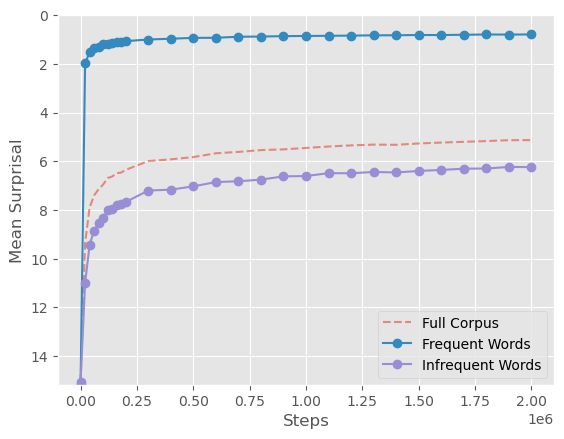

In [11]:
# for each step, average surprisal across all words with at least 512 examples (frequent words)
avg_freq_surprisals = frequent.groupby('Steps').MeanSurprisal.mean().reset_index().assign(Diffs=lambda x: x.MeanSurprisal.diff().fillna(0))

# for each step, average surprisal across all words with only 1 example (infrequent words)
avg_infreq_surprisals = infrequent.groupby('Steps').MeanSurprisal.mean().reset_index().assign(Diffs=lambda x: x.MeanSurprisal.diff().fillna(0))

# for each step, average surprisal across all words
avg_surprisals = surprisals.groupby('Steps').MeanSurprisal.mean().reset_index().assign(Diffs=lambda x: x.MeanSurprisal.diff().fillna(0))

plt.figure()
# plt.xscale('log')
# plt.yscale('log')

plt.plot(avg_surprisals.Steps, avg_surprisals.MeanSurprisal, linestyle='--', alpha=0.6, label='Full Corpus')
plt.plot(avg_freq_surprisals.Steps, avg_freq_surprisals.MeanSurprisal, marker='o', label='Frequent Words')
plt.plot(avg_infreq_surprisals.Steps, avg_infreq_surprisals.MeanSurprisal, marker='o', label='Infrequent Words')

plt.ylim(max(avg_freq_surprisals.MeanSurprisal.max(), avg_infreq_surprisals.MeanSurprisal.max()), 0)
plt.xlabel('Steps')
plt.ylabel('Mean Surprisal')
plt.legend()

print('Frequent words (>= 512 examples):')
print(f"Min surprisal: {avg_freq_surprisals.MeanSurprisal.min():.2f}")
print(f"Max surprisal (excluding the first step): {avg_freq_surprisals.MeanSurprisal.iloc[1:].max():.2f}")
print(f"Average variability (excluding the first step): {avg_freq_surprisals.Diffs.iloc[2:].mean():.2f}\n")

print('Inrequent words (= 1 example):')
print(f"Min surprisal: {avg_infreq_surprisals.MeanSurprisal.min():.2f}")
print(f"Max surprisal (excluding the first step): {avg_infreq_surprisals.MeanSurprisal.iloc[1:].max():.2f}")
print(f"Average variability (excluding the first step): {avg_infreq_surprisals.Diffs.iloc[2:].mean():.2f}\n")

print('Full corpus:')
print(f"Min surprisal: {avg_surprisals.MeanSurprisal.min():.2f}")
print(f"Max surprisal (excluding the first step): {avg_surprisals.MeanSurprisal.iloc[1:].max():.2f}")
print(f"Average variability (excluding the first step): {avg_surprisals.Diffs.iloc[2:].mean():.2f}")

plt.show()

In [14]:
# plot_surprisals(bert_surprisals['Token'].drop_duplicates().tolist(), bert_surprisals)

### Words with different POS

In [12]:
def get_pos_tags(doc_path):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2000000
    pos_dict = {}
    with open(doc_path, 'r', encoding='utf-8') as file:
        text = file.read()
        doc = nlp(text)
        for token in doc:
            if token.text.lower() in pos_dict and not token.pos_ in pos_dict[token.text.lower()]:
                pos_dict[token.text.lower()].append(token.pos_)
            else:
                pos_dict[token.text.lower()] = [token.pos_]
        
    return pd.DataFrame(list(pos_dict.items()), columns=['Token', 'POS'])

In [13]:
def plot_pos_avg(dfs: List[pd.DataFrame]):
    plt.style.use('ggplot')
    plt.figure()
    max_y = 0
    min_y = float('inf')
    for df in dfs:
        avg = (df.groupby('Steps')
                 .agg({'MeanSurprisal': 'mean', 'POS': 'first'})
                 .reset_index()
                 .assign(Diffs=lambda x: x['MeanSurprisal'].diff().fillna(0)))

        plt.plot(avg['Steps'], avg['MeanSurprisal'], 
                 label=f"{avg['POS'].values[0][0]} (var: {avg['Diffs'].iloc[2:].mean():.2f})")
        max_y = avg['MeanSurprisal'].max() if avg['MeanSurprisal'].max() > max_y else max_y
        min_y = avg['MeanSurprisal'].min() if avg['MeanSurprisal'].min() < min_y else min_y

    plt.ylim(max_y, min_y - 1)
    plt.xlabel('Steps')
    plt.ylabel('Mean Surprisal')
    # plt.xscale('log')
    plt.legend()
    plt.show()

In [14]:
document = "../data/wikitext/wikitext103_test.txt"
pos_tags = get_pos_tags(document)
pos_tags

,Token,POS
0,,[SPACE]
1,robert,[PROPN]
2,boulter,[PROPN]
3,is,[AUX]
4,an,[DET]
...,...,...
18746,parlayed,[VERB]
18747,credibility,[NOUN]
18748,ronnie,[PROPN]
18749,pelkey,[PROPN]


In [15]:
merged_df = pd.merge(surprisals, pos_tags, on='Token', how='inner')
merged_df.to_csv('../results/wikitext_surprisals_diffs_pos.csv', sep='\t', index=False)

In [16]:
surps_with_pos = pd.read_csv('../results/wikitext_surprisals_diffs_pos.csv', sep='\t')
surps_with_pos['POS'] = surps_with_pos['POS'].apply(ast.literal_eval)
surps_with_pos

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
0,100th,0,3762,14.619419,0.510996,0.0,2,0.000000,0.000000,[ADJ]
1,100th,20000,10,7.110159,0.964662,0.0,2,-7.509260,0.453667,[ADJ]
2,100th,40000,10,8.165643,1.590769,0.0,2,1.055483,0.626106,[ADJ]
3,100th,60000,7,7.027547,1.110843,0.0,2,-1.138095,-0.479925,[ADJ]
4,100th,80000,1,4.709196,2.413492,0.0,2,-2.318352,1.302649,[ADJ]
...,...,...,...,...,...,...,...,...,...,...
264794,zu,1600000,0,2.781154,3.277767,0.5,4,0.088716,0.182716,[NOUN]
264795,zu,1700000,0,2.847632,3.296625,0.5,4,0.066478,0.018858,[NOUN]
264796,zu,1800000,0,2.986036,3.461543,0.5,4,0.138404,0.164918,[NOUN]
264797,zu,1900000,0,2.985156,3.501315,0.5,4,-0.000880,0.039771,[NOUN]


In [17]:
all_pos_tags = set([pos for pos_list in surps_with_pos['POS'] if isinstance(pos_list, list) for pos in pos_list])
all_pos_tags

{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'SCONJ',
 'VERB',
 'X'}

In [18]:
num_nouns = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'NOUN' in pos_list)]['Token'].nunique()
num_verbs = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'VERB' in pos_list)]['Token'].nunique()
num_adjs = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADJ' in pos_list)]['Token'].nunique()
num_advs = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADV' in pos_list)]['Token'].nunique()

print(f"Total number of nouns: {num_nouns}")
print(f"Total number of verbs: {num_verbs}")
print(f"Total number of adjectives: {num_adjs}")
print(f"Total number of adverbs: {num_advs}")

Total number of nouns: 4680
Total number of verbs: 2713
Total number of adjectives: 1426
Total number of adverbs: 405


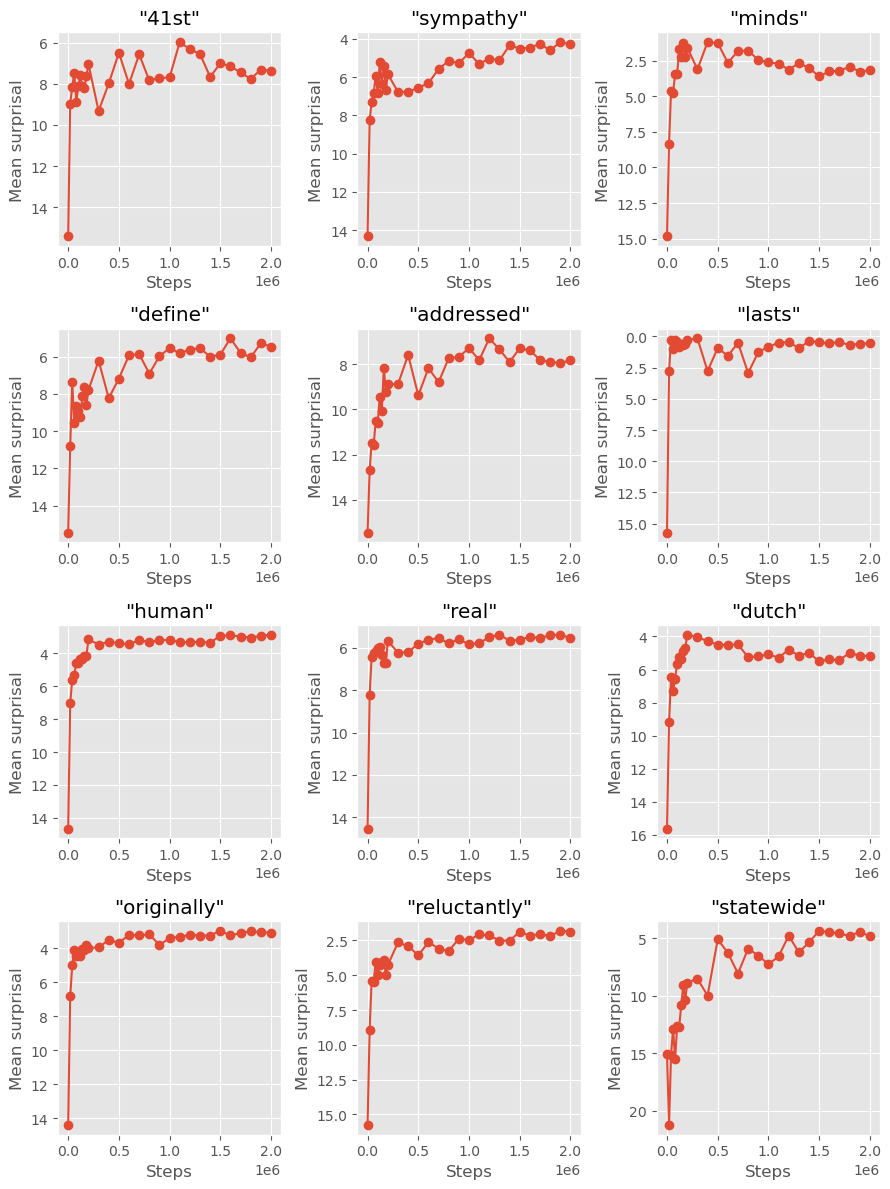

In [19]:
noun = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'NOUN' in pos_list and len(pos_list) == 1)]
verb = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'VERB' in pos_list and len(pos_list) == 1)]
adj = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADJ' in pos_list and len(pos_list) == 1)]
adv = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADV' in pos_list and len(pos_list) == 1)]

noun_sample = noun['Token'].drop_duplicates().sample(3).tolist()
verb_sample = verb['Token'].drop_duplicates().sample(3).tolist()
adj_sample = adj['Token'].drop_duplicates().sample(3).tolist()
adv_sample = adv['Token'].drop_duplicates().sample(3).tolist()

plot_surprisals(
    noun_sample + verb_sample + adj_sample + adv_sample, 
    surps_with_pos
    )

**Learning Curves for Frequent vs. Infrequent Words in the Same Lexical Class.**

*Note: the ‘frequent word’ in this analysis is the one with the highest number of occurrences.*

In [20]:
def plot_all_in_one(words:List[str], surprisals_df):
    plt.style.use('ggplot')
    
    # Create a new figure with a specific size (width=10, height=6)
    plt.figure(figsize=(4, 3))

    for i, word in enumerate(words):   
        word_data = surprisals_df[surprisals_df['Token'] == word]
        if word_data.empty:
            print(f'No data found for the word "{word}"')
            continue

        # Plot the data
        line, = plt.plot(word_data['Steps'], word_data['MeanSurprisal'], marker='o')

        # Annotate the end of the line
        x = word_data['Steps'].iloc[-1]
        y = word_data['MeanSurprisal'].iloc[-1]
        plt.annotate(word, (x, y), ha='center', color=line.get_color())
    
    plt.title('All Words')
    plt.xlabel('Steps')
    plt.ylabel('Mean surprisal')
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.tight_layout()
    plt.show()


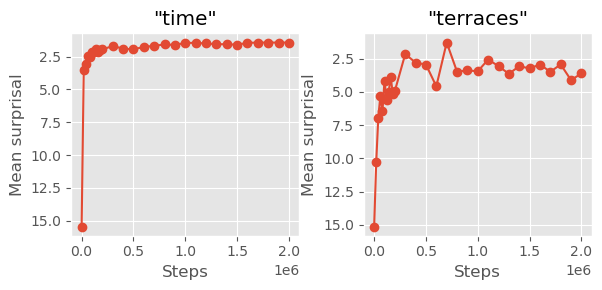

In [21]:
# Nouns
frequent_noun = noun.loc[noun.NumExamples.idxmax(), 'Token']    # 231 examples
infrequent_noun = noun.loc[noun.Token.isin(infrequent.Token), 'Token'].drop_duplicates().sample(1).tolist() # 'clerk' / 'weights'

plot_surprisals([frequent_noun] + infrequent_noun, surps_with_pos)
# plot_all_in_one([frequent_noun] + infrequent_noun, surps_with_pos)

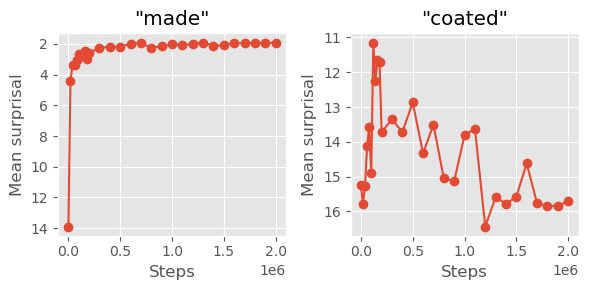

In [22]:
# Verbs
frequent_verb = verb.loc[verb.NumExamples.idxmax(), 'Token']    # 165 examples
infrequent_verb = verb.loc[verb.Token.isin(infrequent.Token), 'Token'].drop_duplicates().sample(1).tolist()

plot_surprisals([frequent_verb] + infrequent_verb, surps_with_pos)

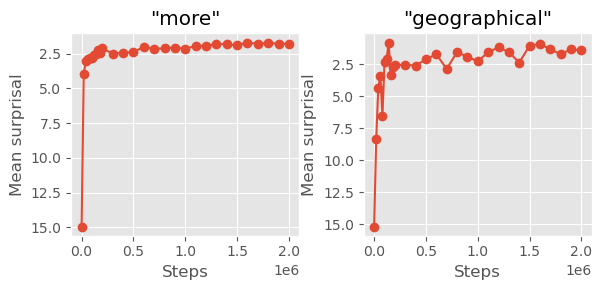

In [23]:
# Adjectives
frequent_adj = adj.loc[adj.NumExamples.idxmax(), 'Token']    # 203 examples
infrequent_adj = adj.loc[adj.Token.isin(infrequent.Token), 'Token'].drop_duplicates().sample(1).tolist()

plot_surprisals([frequent_adj] + infrequent_adj, surps_with_pos)

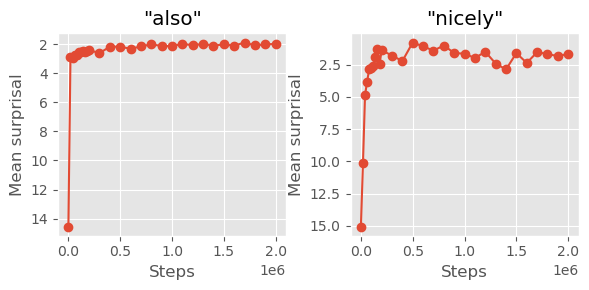

In [24]:
# Adverbs
frequent_adv = adv.loc[adv.NumExamples.idxmax(), 'Token']    # 343 examples
infrequent_adv = adv.loc[adv.Token.isin(infrequent.Token), 'Token'].drop_duplicates().sample(1).tolist()

plot_surprisals([frequent_adv] + infrequent_adv, surps_with_pos)

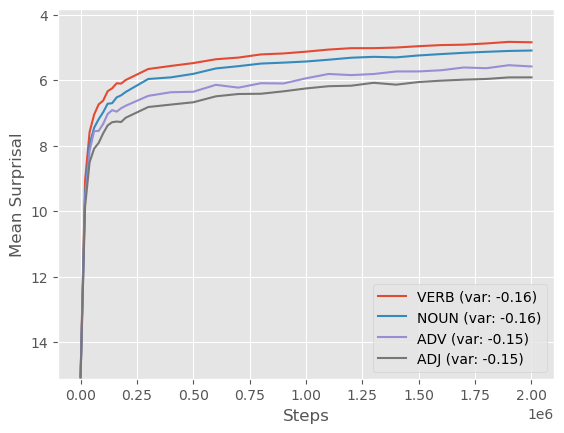

In [25]:
plot_pos_avg([verb, noun, adv, adj])

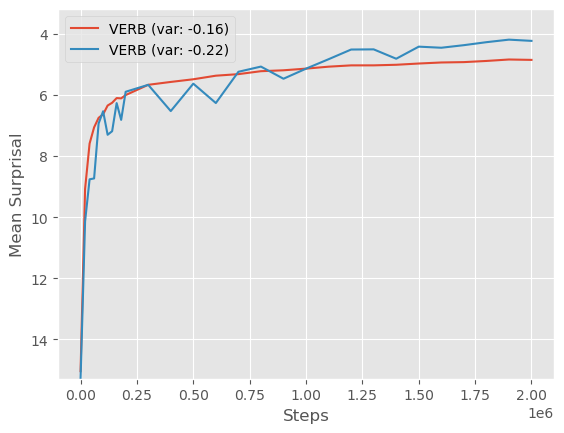

In [26]:
plot_pos_avg([verb, verb[verb['Token'] == 'walk']])

### Top 5 largest and smallest absolute diffs

In [27]:
largest_abs_diffs = merged_df.loc[merged_df['MeanSurprisalDiff'].abs().nlargest(5).index]
largest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
171333,pinyin,20000,0,0.413391,NaN,1.000000,1,-16.335337,0.000000,[NOUN]
37527,certified,20000,0,0.103706,0.213102,1.000000,9,-15.958807,-0.034161,[VERB]
205263,s,20000,0,0.156458,0.832464,0.980469,512,-15.645989,0.436431,[PART]
258449,wasn,20000,0,0.035518,0.026123,1.000000,2,-15.582191,0.016575,"[VERB, NOUN]"
128761,isn,20000,0,0.481655,0.562930,0.666667,3,-15.271394,0.540604,[X]


In [28]:
smallest_abs_diffs = merged_df[merged_df['Steps'] != 0].sort_values(by='MeanSurprisalDiff', key=abs).head(5)
smallest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
203415,romantic,180000,12,6.466520,3.984921,0.222222,9,0.000001,0.162208,[ADJ]
228561,struggle,400000,0,0.741873,NaN,1.000000,1,0.000002,0.000000,[NOUN]
109438,grown,1300000,1,4.066748,3.340114,0.400000,5,0.000002,-0.430809,[VERB]
26819,blanche,1500000,0,0.000110,NaN,1.000000,1,0.000006,0.000000,[NOUN]
110112,gunner,2000000,0,0.001142,NaN,1.000000,1,-0.000007,0.000000,[NOUN]


In [29]:
largest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nlargest(5, 'MeanSurprisalDiff')).reset_index(drop=True)
largest_diffs[largest_diffs['Steps'] != 0]

/tmp/ipykernel_605400/1962239088.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nlargest(5, 'MeanSurprisalDiff')).reset_index(drop=True)


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
5,meadows,20000,28033,25.995031,NaN,0.0,1,12.087551,0.000000,[VERB]
6,regulated,20000,18690,24.933050,NaN,0.0,1,11.021982,0.000000,[VERB]
7,eyebrows,20000,23724,26.026793,NaN,0.0,1,10.978278,0.000000,[NOUN]
8,dwarfs,20000,12753,25.427557,NaN,0.0,1,10.645936,0.000000,[VERB]
9,runaway,20000,10738,25.716511,NaN,0.0,1,9.943949,0.000000,[NOUN]
...,...,...,...,...,...,...,...,...,...,...
140,employs,2000000,682,14.378883,NaN,0.0,1,2.081568,0.000000,[VERB]
141,linebacker,2000000,23,8.991562,NaN,0.0,1,1.918733,0.000000,[NOUN]
142,awaited,2000000,12,7.583819,2.600420,0.0,2,1.430468,2.151388,[VERB]
143,turbulent,2000000,1912,17.191397,0.040059,0.0,2,1.419880,-0.059886,[NOUN]


In [30]:
smallest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nsmallest(5, 'MeanSurprisalDiff')).reset_index(drop=True)
smallest_diffs[smallest_diffs['Steps'] != 0]

/tmp/ipykernel_605400/3927067076.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smallest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nsmallest(5, 'MeanSurprisalDiff')).reset_index(drop=True)


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
5,pinyin,20000,0,0.413391,NaN,1.000000,1,-16.335337,0.000000,[NOUN]
6,certified,20000,0,0.103706,0.213102,1.000000,9,-15.958807,-0.034161,[VERB]
7,s,20000,0,0.156458,0.832464,0.980469,512,-15.645989,0.436431,[PART]
8,wasn,20000,0,0.035518,0.026123,1.000000,2,-15.582191,0.016575,"[VERB, NOUN]"
9,isn,20000,0,0.481655,0.562930,0.666667,3,-15.271394,0.540604,[X]
...,...,...,...,...,...,...,...,...,...,...
140,makers,2000000,11,7.317133,NaN,0.000000,1,-1.767333,0.000000,[NOUN]
141,progressing,2000000,1,4.288303,NaN,0.000000,1,-1.260956,0.000000,[VERB]
142,neighbourhoods,2000000,454,12.842174,NaN,0.000000,1,-1.254994,0.000000,[NOUN]
143,detecting,2000000,391,13.944378,NaN,0.000000,1,-1.216012,0.000000,[VERB]


In [31]:
largest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nlargest(1).index])
largest_abs_diffs[largest_abs_diffs['Steps'] != 0]

/tmp/ipykernel_605400/2835847893.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nlargest(1).index])


,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,171333,pinyin,20000,0,0.413391,NaN,1.000000,1,-16.335337,0.000000,[NOUN]
40000,148627,misses,40000,0,2.977732,2.631396,0.666667,3,-12.677530,0.904474,[NOUN]
60000,78071,eagerly,60000,0,1.739209,NaN,1.000000,1,-10.005972,0.000000,[ADV]
80000,260714,whitehead,80000,699,12.934813,NaN,0.000000,1,8.538087,0.000000,"[ADJ, PROPN]"
100000,154430,neglect,100000,175,11.273901,NaN,0.000000,1,-8.549437,0.000000,[NOUN]
120000,205239,ry,120000,0,1.342942,NaN,1.000000,1,-13.901313,0.000000,[ADP]
140000,205240,ry,140000,423,12.471712,NaN,0.000000,1,11.128770,0.000000,[ADP]
160000,69492,dietary,160000,149,11.057082,NaN,0.000000,1,7.800472,0.000000,[ADJ]
180000,18250,atrocities,180000,262,12.997885,NaN,0.000000,1,8.758473,0.000000,[NOUN]


In [32]:
smallest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nsmallest(1).index])
smallest_abs_diffs[smallest_abs_diffs['Steps'] != 0]

/tmp/ipykernel_605400/584872678.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smallest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nsmallest(1).index])


,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,227680,strengths,20000,602,14.315987,3.633869,0.000000,4,-0.003129,3.351110,[NOUN]
40000,209556,seductive,40000,263,12.590736,0.315317,0.000000,2,-0.000038,-4.173960,[ADJ]
60000,19955,automated,60000,191,11.071678,NaN,0.000000,1,-0.000029,0.000000,[VERB]
80000,183632,proud,80000,0,0.050457,NaN,1.000000,1,0.000034,0.000000,[ADJ]
100000,40692,cities,100000,1,3.060441,3.097222,0.461538,13,-0.000607,-0.064615,[NOUN]
120000,205268,s,120000,0,0.082411,0.514055,0.986328,512,-0.000170,0.051654,[PART]
140000,152025,municipal,140000,25,8.095144,2.473627,0.000000,4,-0.000068,0.412933,[ADJ]
160000,155071,neutron,160000,6,6.023601,NaN,0.000000,1,-0.000062,0.000000,[NOUN]
180000,203415,romantic,180000,12,6.466520,3.984921,0.222222,9,0.000001,0.162208,[ADJ]
